In [1]:
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import os

import utility as util
import astra_wrappers 
import cost_functions 
import reconstruction_alogrithms
import new_solution_generators
import postprocessing

(64, 64)


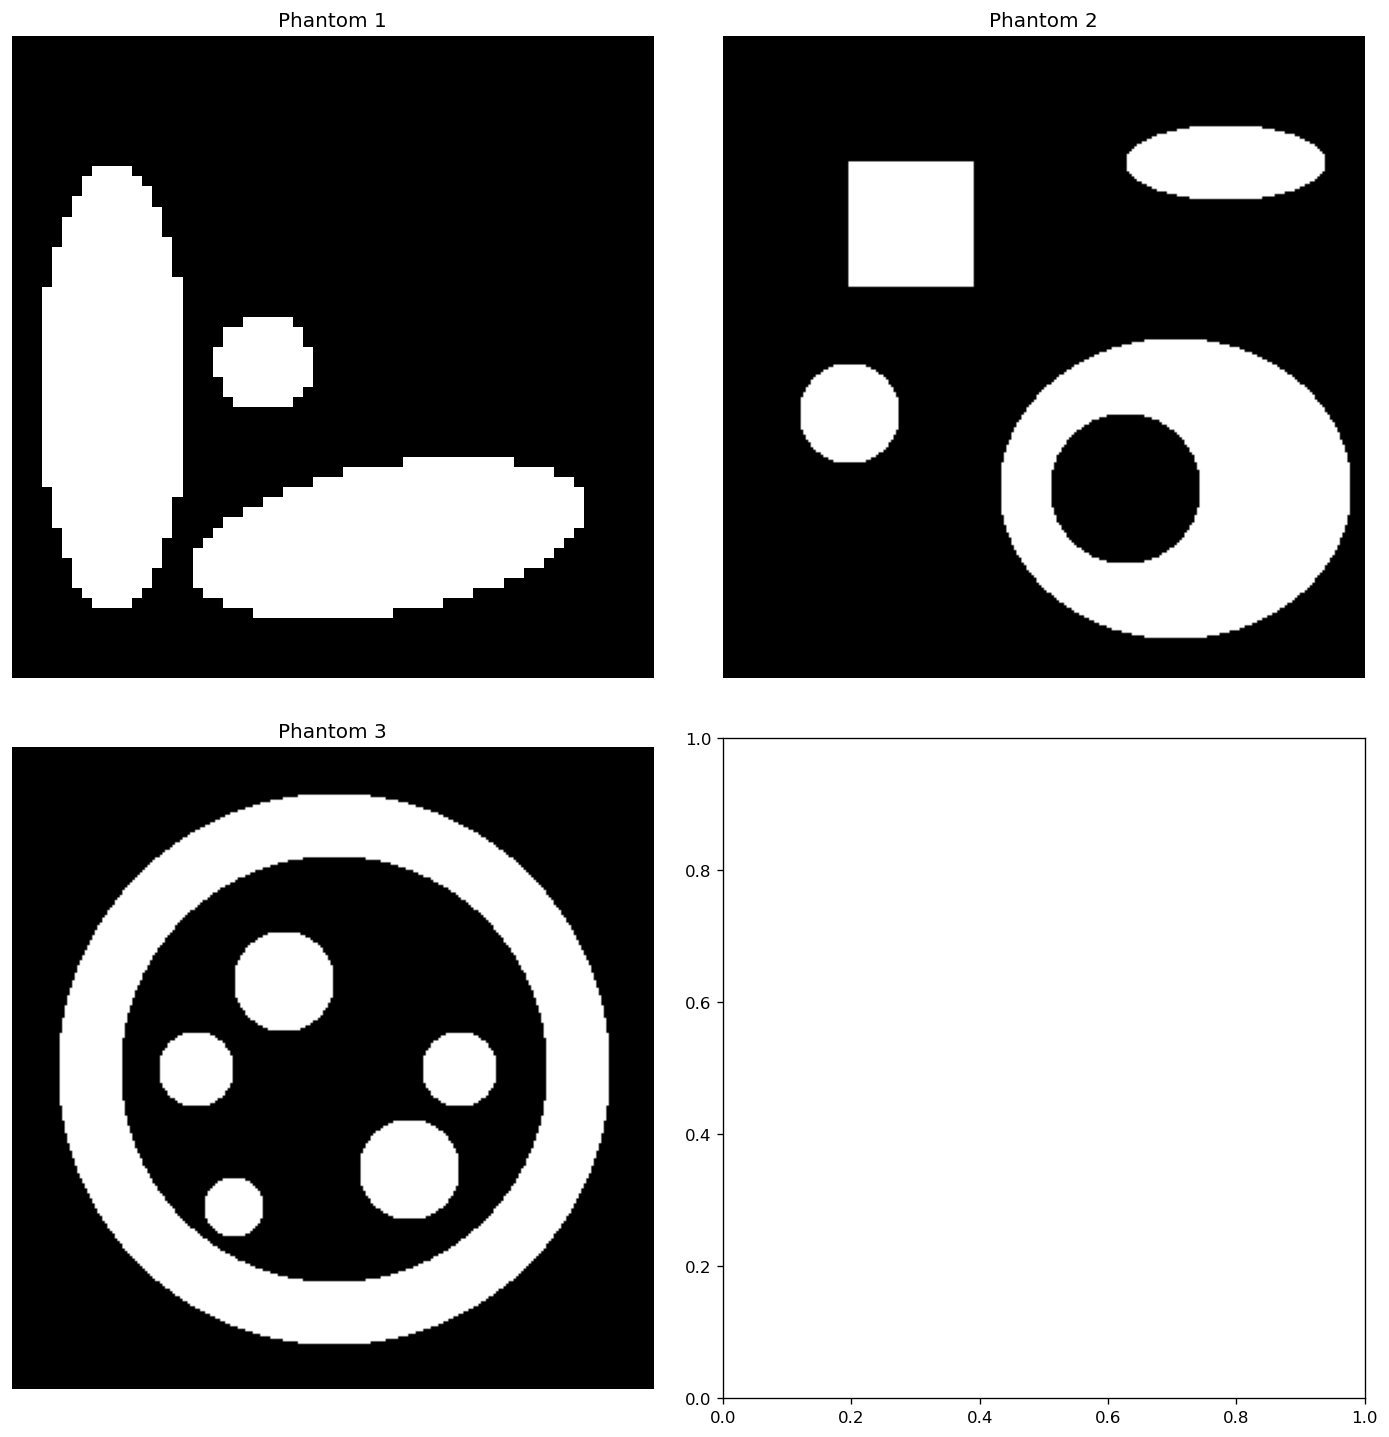

In [2]:
phantom1 = ski.io.imread(os.path.join('data', 'phantom_sz64', 'ph1.png'))
phantom1 = util.fix_img(phantom1)
phantom2 = ski.io.imread(os.path.join('data', 'phantom_sz', 'ph2.png'))
phantom2 = util.fix_img(phantom2)
phantom3 = ski.io.imread(os.path.join('data', 'phantom_sz', 'ph3.png'))
phantom3 = util.fix_img(phantom3)

images = [phantom1, phantom2, phantom3]

titles = ['Phantom 1', 'Phantom 2', 'Phantom 3']

util.plot_images(images, titles)

In [5]:
def SA(image):
    """
    Simulated Annealing reconstruction.
    """
    res = astra_wrappers.preprocess_image(image)

    # --- Parameters---
    params = {
        "T_start": 0.1,
        "cooling_rate": 0.99,
        "max_iter": 50000,
        "area_threshold": 0.5,
        "epsilon": 0.00001,
        "verbose": False,
        "lambda_tv": 0.000,
        "boundary_recalc_freq" : 100
    }

    X0 = astra_wrappers.calculate_X0(res["sinogram"], res["angles"], res["rec_fbp"])

    neighbour_function = new_solution_generators.DeterioratingHammingDistance(
        max_iter=params["max_iter"],
        h_min=1,
        h_max=3
    )

    SA = reconstruction_alogrithms.SimulatedAnnealing(
        X0=X0,
        cost_function=cost_functions.l2_norm,
        cost_function_args=(res["system_matrix"], res["sinogram"].ravel()),
        neighbour_function=neighbour_function,
        params=params
    )

    SA.estimate_starting_temperature(100)
        
    best_img, best_cost, cost_history = SA.run()
    print(f"Best cost: {best_cost}")

SA(phantom1)



(64, 64)
Best cost: 11.29274671287944
